In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob2 import glob
import dask.array

In [2]:
swot_files = sorted(glob('./SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/*.nc'))
swot_ds = xr.open_mfdataset(swot_files[12:22], combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})

In [3]:
# swot_ds.to_netcdf('./swot_L2.nc')

In [4]:
# Assuming swot_ds is your dataset
# Extract the nadir position for the ground track
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values
latitude = swot_ds['latitude'].values
longitude = swot_ds['longitude'].values

In [5]:
#aviso
aviso_path = './aviso_msla_ccs_1d.nc'
aviso_ds = xr.open_dataset(aviso_path)
aviso_ssh = aviso_ds.msla[:, :, 0].data
lon, lat = aviso_ds.lon.data, aviso_ds.lat.data

In [6]:
import numpy as np
def build_swath(msla, lon, lat, swot_longitude, swot_latitude, day):
    
   

    # Define the bounds for the California Current System (CCS)
    cc_bounds = {
        "lon": [360-135, 360-115],
        "lat": [30, 40]
    }

    # Filter SWOT data points within the CCS bounds
    valid_swot_mask = (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & \
                      (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    swot_longitude = swot_longitude[valid_swot_mask]
    swot_latitude = swot_latitude[valid_swot_mask]

    # Find bounding rectangle for SWOT data
    min_lon, max_lon = np.min(swot_longitude), np.max(swot_longitude)
    min_lat, max_lat = np.min(swot_latitude), np.max(swot_latitude)

    # Generate a meshgrid from the lon and lat arrays
    LON, LAT = np.meshgrid(lon, lat)
    
    # Identify the SWOT points that intersect the CCS bounds
    intersect_mask = (
        (swot_latitude >= cc_bounds["lat"][0]) & (swot_latitude <= cc_bounds["lat"][1]) & 
        (swot_longitude >= cc_bounds["lon"][0]) & (swot_longitude <= cc_bounds["lon"][1])
    )

    intersected_lons = swot_longitude[intersect_mask]
    intersected_lats = swot_latitude[intersect_mask]
    
    # For the purpose of demonstration, I will use a simple nearest neighbor interpolation on the AVISO grid
    # This approach might not be the best depending on your data distribution, so consider other interpolation techniques if needed.
    msla_interpolated = np.ones_like(msla) * 1e20
    for s_lon, s_lat in zip(intersected_lons, intersected_lats):
        nearest_lon_idx = np.abs(lon - s_lon).argmin()
        nearest_lat_idx = np.abs(lat - s_lat).argmin()
        
        msla_interpolated[nearest_lat_idx, nearest_lon_idx] = msla[nearest_lat_idx, nearest_lon_idx]
        
    msla_interpolated = np.ma.masked_equal(msla_interpolated, 1e20)

    # Generate an X-shaped mask
    mask_upper_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_upper_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT > (min_lat + max_lat) / 2)
    mask_lower_left = np.logical_and(LON < (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)
    mask_lower_right = np.logical_and(LON > (min_lon + max_lon) / 2, LAT < (min_lat + max_lat) / 2)
    
    diagonal_mask_1 = (LAT - min_lat) / (max_lat - min_lat) > (LON - min_lon) / (max_lon - min_lon)
    diagonal_mask_2 = (LAT - min_lat) / (max_lat - min_lat) < (LON - min_lon) / (max_lon - min_lon)

    mask_left = mask_upper_left * diagonal_mask_1 + mask_lower_left * diagonal_mask_2
    mask_right = mask_upper_right * diagonal_mask_2 + mask_lower_right * diagonal_mask_1

    yswath_index_left = np.ma.masked_where(~mask_left, LAT)
    xswath_index_left = np.ma.masked_where(~mask_left, LON)
    
    yswath_index_right = np.ma.masked_where(~mask_right, LAT)
    xswath_index_right = np.ma.masked_where(~mask_right, LON)
    
    # Creating the xindex, yindex, tindex arrays
    yvalid_index = np.append(yswath_index_left.compressed(), yswath_index_right.compressed()) 
    xvalid_index = np.append(xswath_index_left.compressed(), xswath_index_right.compressed())
    
    tindex, xindex, yindex = [], [], []
    xindex =  np.tile(xvalid_index, len(day))
    yindex =  np.tile(yvalid_index, len(day))
    for dd in day:
        tmp = np.tile(dd, len(yvalid_index))
        tindex = np.append(tindex, tmp)
        # Convert masked longitude and latitude values to indices
    yvalid_indices = np.where(np.logical_or(mask_left, mask_right))
    yvalid_index = yvalid_indices[0]
    xvalid_index = yvalid_indices[1]

    # Creating the xindex, yindex, tindex arrays
    tindex = np.array([dd for dd in day for _ in range(len(yvalid_index))])

    return xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, mask_left, mask_right, msla_interpolated

In [7]:
# Test the function with your data
swot_longitude = longitude  # Assuming 'longitude' is defined somewhere in your environment
swot_latitude = latitude  # Assuming 'latitude' is defined somewhere in your environment
msla = aviso_ssh
day  = np.array([0])
xindex, yindex, tindex, yswath_index_left, yswath_index_right, mask_left, mask_right,  msla_filtered= build_swath(msla, lon, lat, swot_longitude, swot_latitude, day)

In [8]:
xindex, yindex, tindex

(array([ 83,  84,  85, ..., 181, 182, 183]),
 array([  0,   0,   0, ..., 103, 103, 103]),
 array([0, 0, 0, ..., 0, 0, 0]))

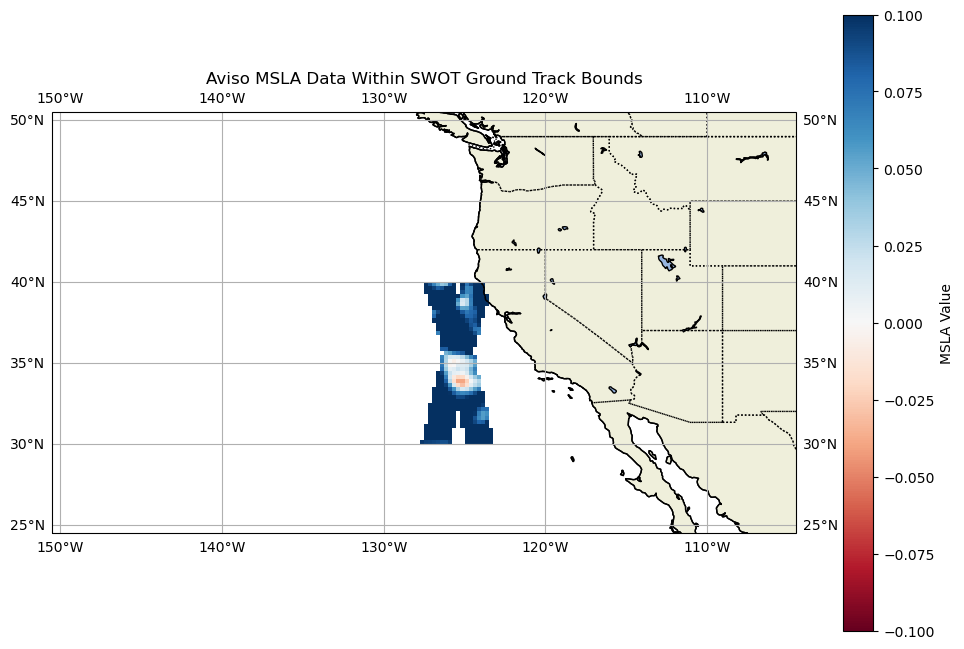

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ... [Your function or data loading code]

# Plotting on a 2D map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set background color to white
# ax.background_patch.set_facecolor('white')
plt.pcolormesh(lon, lat, msla_filtered, cmap= 'RdBu', vmin = -.1, vmax = 0.1)
plt.colorbar(label='MSLA Value')
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.gridlines(draw_labels=True)
plt.title('Aviso MSLA Data Within SWOT Ground Track Bounds')
plt.savefig("./selected_aviso_ssh.png")
